In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import math
%matplotlib inline
import matplotlib as plt

In [2]:
negative_with_seq = pd.read_csv("./data/negative_examples.csv")
positive_with_seq = pd.read_csv("./data/positive_examples.csv")

In [3]:
n = positive_with_seq["seq_new"].apply(lambda x: True if "N" in x else False)
np.where(n == True)

(array([ 15218,  15223,  15224, ..., 153676, 153677, 153678]),)

In [4]:
bases = dict(zip("ACGTN", [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]))
bases 


{'A': [1, 0, 0, 0, 0],
 'C': [0, 1, 0, 0, 0],
 'G': [0, 0, 1, 0, 0],
 'T': [0, 0, 0, 1, 0],
 'N': [0, 0, 0, 0, 1]}

In [5]:
X_positive = []
def encode(row):
    result = []
    for base in row:
        result.append(bases[base])
        
    X_positive.append(result)
positive_with_seq["seq_new"].apply(encode)
X_positive[0][0]

[1, 0, 0, 0, 0]

In [6]:
X_negative = []
def encode_neg(row):
    result = []
    for base in row:
        result.append(bases[base])
        
    X_negative.append(result)
negative_with_seq["seq_new"].apply(encode_neg)
X_negative[0][0]

[0, 0, 0, 1, 0]

In [8]:
features = np.concatenate((X_positive, X_negative), axis=0)
features.shape

(166348, 400, 5)

In [10]:
d = [bases["A"],bases["C"]]
e = [bases["A"],bases["C"], bases["A"], bases["C"]]
e

In [11]:
test_con = np.concatenate((d, e), axis=0)
test_con

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [12]:
test_con.shape

(6, 5)

In [13]:
Y_pos = [[1]] * len(X_positive)
Y_neg = [[0]] * len(X_negative)

In [14]:
labels = np.concatenate((Y_pos, Y_neg), axis=0)

In [75]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(features,
                                                    labels,
                                                    test_size=0.33,
                                                    random_state=42)


In [16]:
X_train.shape

(111453, 400, 5)

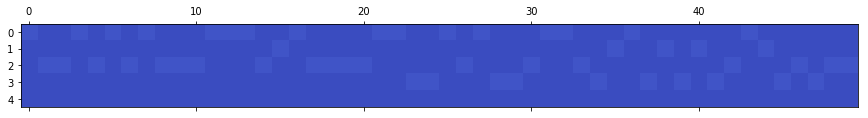

In [36]:
plt.pyplot.figure(figsize=(15, 5))
plt.pyplot.matshow(X_train[999,:50,:].transpose(), vmin=0, vmax=50, cmap=plt.pyplot.cm.coolwarm, fignum=0)


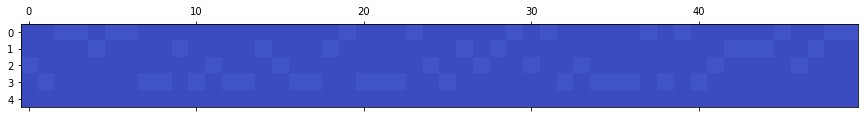

In [38]:
plt.pyplot.figure(figsize=(15, 5))
plt.pyplot.matshow(X_train[998,:50,:].transpose(), vmin=0, vmax=50, cmap=plt.pyplot.cm.coolwarm, fignum=0)


In [77]:
train_data = X_train
train_labels = y_train
eval_data = y_train
eval_labels = y_test
layer_1_nodes = 50
layer_2_nodes = 100
layer_3_nodes = 50
learning_rate = 0.001
training_epochs = 5
number_of_outputs = 1
number_of_inputs = train_data.shape[1]
number_of_inputs
tf.reset_default_graph()
# Input Layer
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, shape=(None, 400, 5), name="X")
    
# Layer 1
with tf.variable_scope('layer_1'):
    weights = tf.get_variable("weights1", shape=[400, 5, layer_1_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases1", shape=[layer_1_nodes], initializer=tf.zeros_initializer())
    layer_1_output = tf.nn.relu(tf.einsum('nij,ijk->nik', X, weights) + biases)


# Layer 2
with tf.variable_scope('layer_2'):
    weights = tf.get_variable("weights2", shape=[400, layer_1_nodes, layer_2_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases2", shape=[layer_2_nodes], initializer=tf.zeros_initializer())
    layer_2_output = tf.nn.relu(tf.einsum('nij,ijk->nik', layer_1_output, weights) + biases)

# Layer 3
with tf.variable_scope('layer_3'):
    weights = tf.get_variable("weights3", shape=[400, layer_2_nodes, layer_3_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases3", shape=[layer_3_nodes], initializer=tf.zeros_initializer())
    layer_3_output = tf.nn.relu(tf.einsum('nij,ijk->nik', layer_2_output, weights) + biases)

with tf.variable_scope('layer_drop'):    
  dropout = tf.layers.dropout(
      inputs=layer_3_output, rate=0.4)

# Output Layer
with tf.variable_scope('output'):
    weights = tf.get_variable("weights4", shape=[400, layer_3_nodes, number_of_outputs], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases4", shape=[number_of_outputs], initializer=tf.zeros_initializer())
    prediction = tf.einsum('nij,ijk->nik', dropout, weights) + biases
    
with tf.variable_scope('cost'):
    Y = tf.placeholder(tf.float32, shape=(None, 1), name="Y")
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))   
    
with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Create a summary operation to log the progress of the network
with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()
    
RUN_NAME = "run 1 with 5 nodes"
# Initialize a session so that we can run TensorFlow operations
with tf.Session() as session:

    # Run the global variable initializer to initialize all variables and layers of the neural network
    session.run(tf.global_variables_initializer())

    # Create log file writers to record training progress.
    # We'll store training and testing log data separately.
    training_writer = tf.summary.FileWriter("./logs/{}/training".format(RUN_NAME), session.graph)
    testing_writer = tf.summary.FileWriter("./logs/{}/testing".format(RUN_NAME), session.graph)

    # Run the optimizer over and over to train the network.
    # One epoch is one full run through the training data set.
    for epoch in range(training_epochs):

        # Feed in the training data and do one step of neural network training
        session.run(optimizer, feed_dict={X: train_data, Y: train_labels})

        # Every few training steps, log our progress
        # Get the current accuracy scores by running the "cost" operation on the training and test data sets
        training_cost, training_summary = session.run([cost, summary], feed_dict={X: train_data, Y:train_labels})
        testing_cost, testing_summary = session.run([cost, summary], feed_dict={X: eval_data, Y:eval_labels})

        # Write the current training status to the log files (Which we can view with TensorBoard)
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)

        # Print the current training status to the screen
        print("Epoch: {} - Training Cost: {}  Testing Cost: {}".format(epoch, training_cost, testing_cost))

    # Training is now complete!

    # Get the final accuracy scores by running the "cost" operation on the training and test data sets
    final_training_cost = session.run(cost, feed_dict={X: train_data, Y: train_labels})
    final_testing_cost = session.run(cost, feed_dict={X: eval_data, Y: eval_labels})

    print("Final Training cost: {}".format(final_training_cost))
    print("Final Testing cost: {}".format(final_testing_cost))


In [45]:
layer_3_nodes

5

In [46]:
prediction.shape


TensorShape([Dimension(400), Dimension(400), Dimension(1)])

In [47]:
eval_data.shape

(111453, 1)

In [73]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


batch_size = 128
num_classes = 2
epochs = 12

# input image dimensions
img_rows, img_cols = 400, 5

# the data, split between train and test sets
x_train = X_train[:20].reshape(20,400,5,1)
y_train = y_train[:20]
x_test = X_test[:20].reshape(20,400,5,1)
y_test = y_test[:20]

input_shape = (400, 5, 1)


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: Error when checking target: expected dense_7 to have 4 dimensions, but got array with shape (20, 1)

In [58]:
x_train.shape

(20, 400, 5)

In [68]:
y_train[0]

array([1])

array([[[[1],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [1],
         [0],
         [0],
         [0]],

        [[1],
         [0],
         [0],
         [0],
         [0]],

        ..., 
        [[0],
         [1],
         [0],
         [0],
         [0]],

        [[1],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [1],
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [1],
         [0],
         [0]],

        [[0],
         [0],
         [1],
         [0],
         [0]],

        [[1],
         [0],
         [0],
         [0],
         [0]],

        ..., 
        [[0],
         [0],
         [0],
         [1],
         [0]],

        [[1],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [1],
         [0]]],


       [[[0],
         [0],
         [0],
         [1],
         [0]],

        [[0],
         [0],
    